In [4]:
# Import necessary libraries and modules
import numpy as np  # Assuming numpy is used for array operations
from sigpy import backend, util
#from backend import get_device  # Importing get_device function from backend_module

In [5]:
# Define a base class Alg for iterative algorithms
class Alg(object):
    
    # Constructor to initialize the maximum number of iterations
    def __init__(self, max_iter):
        self.max_iter = max_iter  # Maximum number of iterations
        self.iter = 0  # Current iteration

    # Abstract method for performing one update step
    def _update(self):
        raise NotImplementedError

    # Method to check if the algorithm is done
    def _done(self):
        return self.iter >= self.max_iter

    # Method to perform one update step and increment iteration count
    def update(self):
        self._update()
        self.iter += 1

    # Method to check if the algorithm is done
    def done(self):
        return self._done()

In [ ]:
##In the provided code, the preconditioner (P) is an optional parameter that can be passed to the ConjugateGradient class during initialization. The purpose of a preconditioner in iterative methods like conjugate gradient is to improve the convergence properties of the algorithm by transforming the system of equations into a more suitable form.

##Here's what the preconditioner is doing in the code:

##Initialization: In the constructor of the ConjugateGradient class, if a preconditioner is provided (P is not None), the input residual r is transformed using the preconditioner to obtain z. This transformed residual z is used as the initial search direction p. If no preconditioner is provided, z is set equal to r.
##Update Step: During each iteration of the conjugate gradient algorithm, if a preconditioner is provided, the residual r is updated using the preconditioned residual z. This update is performed before computing the new search direction p.

In [7]:




# Define a class ConjugateGradient that inherits from Alg
class ConjugateGradient(Alg):
    
    # Constructor for ConjugateGradient class
    def __init__(self, A, b, x, P=None, max_iter=100, tol=0):
        # Initialize parameters
        self.A = A  # Linear operator A
        self.b = b  # Observation
        self.P = P  # Preconditioner
        self.x = x  # Variable
        self.tol = tol  # Tolerance for stopping condition
        self.device = backend.get_device(x)  # Get the device (e.g., CPU or GPU) for the variable x
        with self.device:
            xp = self.device.xp  # Get the backend (e.g., numpy or cupy) for the device
            # Compute the initial residual
            self.r = b - self.A(self.x)

            # Apply preconditioner if provided
            if self.P is None:
                z = self.r
            else:
                z = self.P(self.r)

            # Initialize search direction
            if max_iter > 1:
                self.p = z.copy()
            else:
                self.p = z

            # Initialize variables for conjugate gradient
            self.not_positive_definite = False
            self.rzold = xp.real(xp.vdot(self.r, z))
            self.resid = self.rzold.item() ** 0.5

            super().__init__(max_iter)  # Call the constructor of the base class

    # Method to perform one update step of the conjugate gradient algorithm
    def _update(self):
        with self.device:
            xp = self.device.xp
            Ap = self.A(self.p)  # Compute A times the search direction p
            pAp = xp.real(xp.vdot(self.p, Ap)).item()  # Compute dot product of p and Ap
            if pAp <= 0:  # Check if pAp is not positive definite
                self.not_positive_definite = True
                return

            # Compute step size alpha
            self.alpha = self.rzold / pAp
            # Update solution
            util.axpy(self.x, self.alpha, self.p)
            if self.iter < self.max_iter - 1:
                # Update residual
                util.axpy(self.r, -self.alpha, Ap)
                # Apply preconditioner if provided
                if self.P is not None:
                    z = self.P(self.r)
                else:
                    z = self.r

                rznew = xp.real(xp.vdot(self.r, z))
                beta = rznew / self.rzold
                util.xpay(self.p, beta, z)
                self.rzold = rznew

            self.resid = self.rzold.item() ** 0.5

    # Method to check if the algorithm is done
    def _done(self):
        return (
            self.iter >= self.max_iter
            or self.not_positive_definite
            or self.resid <= self.tol
        )


This code snippet defines an iterative algorithm using the conjugate gradient method to solve a linear system of equations Ax=b, where A is a Hermitian linear operator,b is the observation, and 

x is the variable to be solved for. The algorithm can be used iteratively until a termination condition is met.

This example initializes the linear operator 

A, observation 

b, initial guess 

x, and preconditioner 

P. Then, it creates an instance of the ConjugateGradient solver and iteratively updates the solution until a termination condition is met. Finally, it prints the final solution x.





In [8]:
# Assume backend_module contains the necessary backend functions like get_device
#import backend_module
# Assume util module contains necessary utility functions like axpy, xpay
#import util

# Dummy implementation of Linear Operator A (can be replaced with actual implementation)
def linear_operator_A(x):
    return x

# Dummy observation b (can be replaced with actual observation)
b = np.array([1, 2, 3])

# Dummy initial guess for the variable x (can be replaced with actual initial guess)
x = np.zeros_like(b)

# Dummy preconditioner P (can be replaced with actual preconditioner if available)
P = None

# Create an instance of ConjugateGradient solver
solver = ConjugateGradient(linear_operator_A, b, x, P)

# Perform iterative updates until convergence or maximum iterations reached
while not solver.done():
    solver.update()

# Print the final solution
print("Final solution x:", solver.x)


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

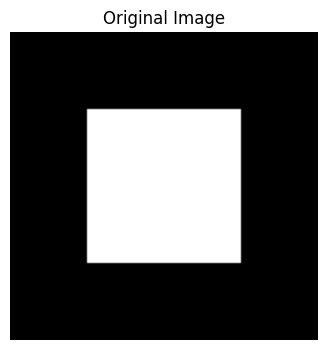

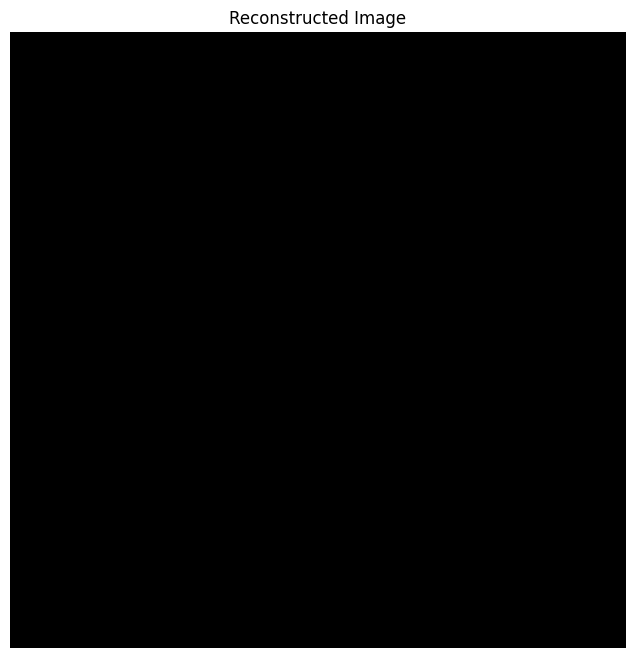

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy image dimensions
image_size = 128

# Generate a synthetic image (e.g., a square)
image = np.zeros((image_size, image_size))
image[image_size//4:3*image_size//4, image_size//4:3*image_size//4] = 1

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Create synthetic undersampled k-space data
# For simplicity, we'll perform random undersampling
undersampling_factor = 4
k_space = np.fft.fftshift(np.fft.fft2(image))  # Compute FFT of the image
undersampled_k_space = k_space.copy()
undersampled_k_space[np.random.rand(*k_space.shape) > 1/undersampling_factor] = 0  # Random undersampling

# Define linear operator A to perform inverse FFT
def linear_operator_A(x):
    return np.fft.ifft2(np.fft.ifftshift(x))

# Observation is the undersampled k-space data
b = undersampled_k_space

# Initial guess for the image (all zeros)
x_initial_guess = np.zeros_like(image)

# Dummy preconditioner (identity matrix)
def preconditioner(x):
    return x

# Maximum number of iterations
max_iterations = 100

# Tolerance for stopping condition
tolerance = 1e-6

# Perform image reconstruction using conjugate gradient method
#from your_module import ConjugateGradient  # Import ConjugateGradient from your module
solver = ConjugateGradient(linear_operator_A, b, x_initial_guess, P=preconditioner,
                           max_iter=max_iterations, tol=tolerance)
while not solver.done():
    solver.update()

# Get the reconstructed image
reconstructed_image = solver.x.real  # Take real part to remove numerical artifacts

# Display the reconstructed image
plt.figure(figsize=(8, 8))
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


In this example:

We generate a synthetic image (a square) and display it.
We perform random undersampling in k-space to simulate the undersampled data.
We define a linear operator linear_operator_A that performs the inverse FFT.
The observation b is the undersampled k-space data.
We define an initial guess for the image, a dummy preconditioner, maximum iterations, and a tolerance for the conjugate gradient solver.
We use the conjugate gradient method to reconstruct the image from the undersampled k-space data.
Finally, we display the reconstructed image.